# 未来価格の予測  

## 予測対象: 未来の価格と今の価格の値上がり率（対数）  
$$y = \log{\frac{future\_price}{current\_price}} = \log{future\_price} - \log{current\_price}$$  

直接求めるか，未来価格を予測して比率を計算するか．  

## 使用する特徴量  
- 画像の特徴量（SwinTransformerで抽出）
- 直近50件の価格推移（LSTMで抽出）   
- 各コレクションの価格平均  

## モデルの構成  
- 画像の特徴量をSwinTransformerで抽出（64）  
- 価格推移を特徴量として抽出  
- 上2つと価格平均を結合して，機械学習モデルで予測（モデルは要検討）  

### 結果  
- linear regression: mae 0.322  
- lightgbm: mae 0.246  
- NN: 0.275  

In [1]:
from comet_ml import Experiment

import os
import sys
import gc
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import lightgbm as lgb
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optim
import tensorflow.keras.activations as activations
import matplotlib.pyplot as plt

sys.path.append('../src')
sys.path.append('../Swin-Transformer-TF')
from ml_utils import *
from utils import *
from swintransformer import SwinTransformer

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 20


%matplotlib inline

In [2]:
TABLE_DIR = "../data/taskA/table"
en_df = pd.read_csv(os.path.join(TABLE_DIR, "ensemble_data.csv"))  # 各画像データをSwinTransformerで特徴量抽出したデータを含む
en_df = en_df.drop('target', axis=1)
en_df = en_df.rename(columns={'price_0': 'target'})
en_df['target'] = en_df['target'].apply(lambda x: np.log1p(x))

print(f"ensemble data shape: {en_df.shape}")

ensemble data shape: (21747, 235)


In [3]:
en_df = en_df.query("price_1 != 0").reset_index(drop=True)
en_df = en_df[en_df['collection.name'] != 'Angry Apes United']  # 1つしか存在しないもの
collection_means = en_df.groupby('collection.name')['price_1'].mean()
en_df['target_encoding'] = en_df['collection.name'].map(collection_means)
print(f"drop 1 transaction data: {en_df.shape}")

drop 1 transaction data: (13530, 236)


In [4]:
def create_model(len_seq: int = 49, input_dim: int = 1, output_dim: int = 1):
    inputs = layers.Input(shape=(len_seq, input_dim))
    lstm = layers.LSTM(64)(inputs)
    outputs = layers.Dense(output_dim)(lstm)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=losses.mean_squared_error, optimizer=optim.Adam())
    return model

In [5]:
model = create_model()
model.summary()

2021-12-30 07:57:22.592524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 07:57:22.634313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 07:57:22.634735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 07:57:22.635477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [6]:
features = [f"price_{i}" for i in range(1, 50)]
target = 'target'

X = en_df[features].values.reshape(-1, 49, 1)
y = en_df[target].values

model.fit(X, y, validation_split=0.1, epochs=20, batch_size=64)

Epoch 1/20


2021-12-30 07:57:23.474684: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-30 07:57:25.036685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


  1/191 [..............................] - ETA: 8:44 - loss: 4.6698

2021-12-30 07:57:26.115749: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


191/191 [==============================] - 3s 3ms/step - loss: 1.5026 - val_loss: 0.2438
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 1.1072 - val_loss: 0.3128
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0677 - val_loss: 0.1693
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0654 - val_loss: 0.2682
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0481 - val_loss: 0.2188
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0404 - val_loss: 0.2278
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0556 - val_loss: 0.1280
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0380 - val_loss: 0.1267
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0205 - val_loss: 0.1922
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0284 - val_loss: 0.2902
Epoch 11/2

In [7]:
base_model = models.Sequential(model.layers[:-1])
seq_features = base_model.predict(X)

seq_names = [f"seq_feature{i}" for i in range(64)]
en_df[seq_names] = seq_features

In [8]:
image_names = [f"image_feature{i}" for i in range(64)]
use_cols = seq_names + image_names + ['target_encoding']
target = 'target'

In [9]:
def eval_model(df, features, target, model, model_name):
    kf = StratifiedKFold(n_splits=4, random_state=6174, shuffle=True)
    rmse_scores = np.array([])
    mae_scores = np.array([])
    model_no = 0
    models = {}

    for train_idx, val_idx in kf.split(df, df['collection.name'].values):
        train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

        enc = train_df.groupby(['collection.name'])['target'].mean()
        train_df['target_encoding'] = train_df['collection.name'].map(enc)
        val_df['target_encoding'] = val_df['collection.name'].map(enc)

        train_X, val_X = train_df[features].values, val_df[features].values
        train_y, val_y = train_df[target].values, val_df[target].values

        sc = StandardScaler()
        train_X = sc.fit_transform(train_X)
        val_X = sc.transform(val_X)

        model.fit(train_X, train_y)
        pred = model.predict(val_X)
        rmse = np.sqrt(mean_squared_error(val_y, pred))
        mae = mean_absolute_error(val_y, pred)

        rmse_scores = np.append(rmse_scores, rmse)
        mae_scores = np.append(mae_scores, mae)

        models[f"model_{model_no}"] = model
        model_no += 1

    print(f"Use model: {model_name}")
    print(f"RMSE Score: {rmse_scores.mean()}")
    print(f"MAE Score: {mae_scores.mean()}")

    return models

In [10]:
linear_models = eval_model(en_df, use_cols, target, LinearRegression(), "Linear Regression")

Use model: Linear Regression
RMSE Score: 1.623705685446118
MAE Score: 0.3297920608009465


In [11]:
lgb_models = eval_model(en_df, use_cols, target, lgb.LGBMRegressor(), "Light GBM")

Use model: Light GBM
RMSE Score: 0.6436164986904097
MAE Score: 0.24455112306245802


In [12]:
X = en_df[use_cols].values
pred = np.zeros(len(X))
for model in lgb_models.values():
    pred += model.predict(StandardScaler().fit_transform(X))
en_df['pred'] = pred / 4

In [13]:
en_df[['target', 'pred']].describe()

,target,pred
count,13530.000000,13530.000000
mean,1.420694,1.532189
std,1.446046,1.214016
min,0.000000,-0.075339
25%,0.463734,0.921398
50%,1.029619,1.141290
75%,1.856298,1.547898
max,19.336971,13.289938


In [14]:
en_df['real_rate'] = en_df['target'] - en_df['price_1'].apply(lambda x: np.log1p(x))
en_df['pred_rate'] = en_df['pred'] - en_df['price_1'].apply(lambda x: np.log1p(x))
en_df[['real_rate', 'pred_rate']].describe()

,real_rate,pred_rate
count,13530.000000,13530.000000
mean,0.213703,0.325198
std,1.036265,0.956248
min,-18.044203,-16.984454
25%,-0.044068,-0.036571
50%,0.082541,0.376815
75%,0.303387,0.589546
max,18.749185,12.513864


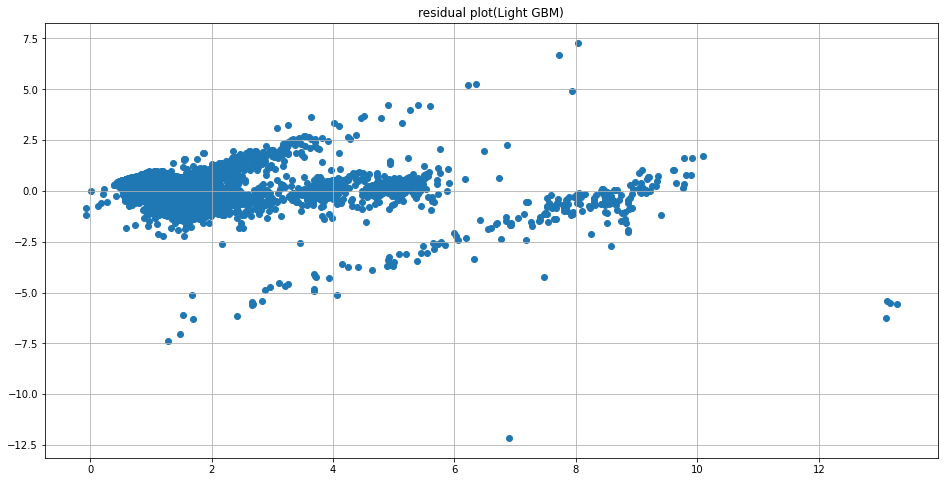

In [15]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred'], en_df['pred'] - en_df['target'])
plt.title("residual plot(Light GBM)")
plt.grid(True)
plt.show()

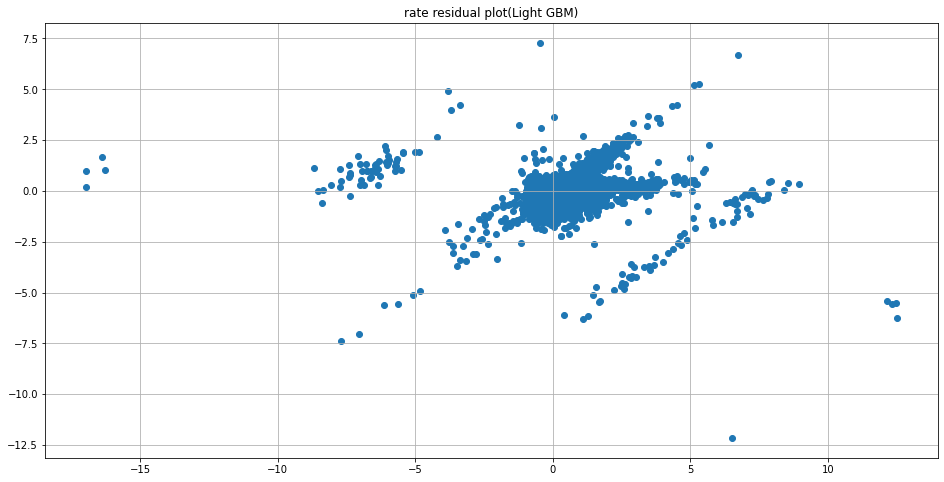

In [16]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_rate'], en_df['pred_rate'] - en_df['real_rate'])
plt.title("rate residual plot(Light GBM)")
plt.grid(True)
plt.show()

In [17]:
X = en_df[use_cols].values
pred = np.zeros(len(X))
for model in linear_models.values():
    pred += model.predict(StandardScaler().fit_transform(X))

en_df['pred_linear'] = pred / 4
en_df['pred_rate_linear'] = en_df['pred_linear'] - en_df['price_1'].apply(lambda x: np.log1p(x))

en_df[['target', 'pred_linear']].describe()

,target,pred_linear
count,13530.000000,13530.000000
mean,1.420694,1.421550
std,1.446046,1.652736
min,0.000000,-36.495402
25%,0.463734,0.416807
50%,1.029619,0.982735
75%,1.856298,1.886656
max,19.336971,87.904097


In [18]:
en_df[['real_rate', 'pred_rate_linear']].describe()

,real_rate,pred_rate_linear
count,13530.000000,13530.000000
mean,0.213703,0.214559
std,1.036265,1.201181
min,-18.044203,-36.907512
25%,-0.044068,-0.099254
50%,0.082541,0.095192
75%,0.303387,0.366090
max,18.749185,83.641418


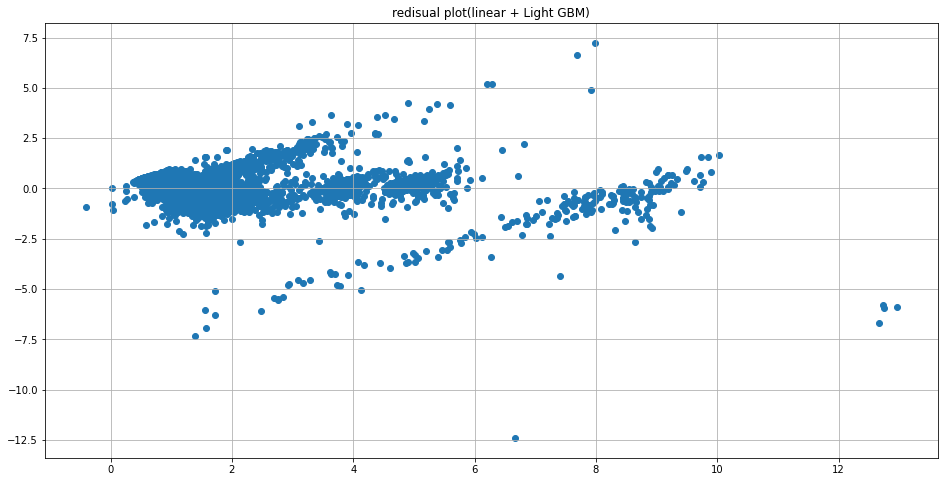

In [19]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_linear']*0.038 + en_df['pred']*0.962, en_df['pred_linear']*0.038 + en_df['pred']*0.962- en_df['target'])
plt.grid(True)
plt.title("redisual plot(linear + Light GBM)")
plt.show()

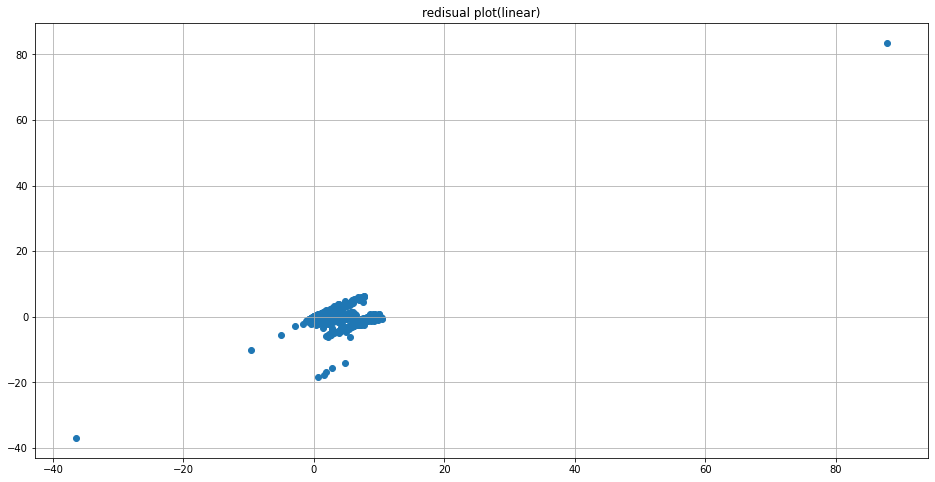

In [20]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_linear'], en_df['pred_linear'] - en_df['target'])
plt.grid(True)
plt.title("redisual plot(linear)")
plt.show()

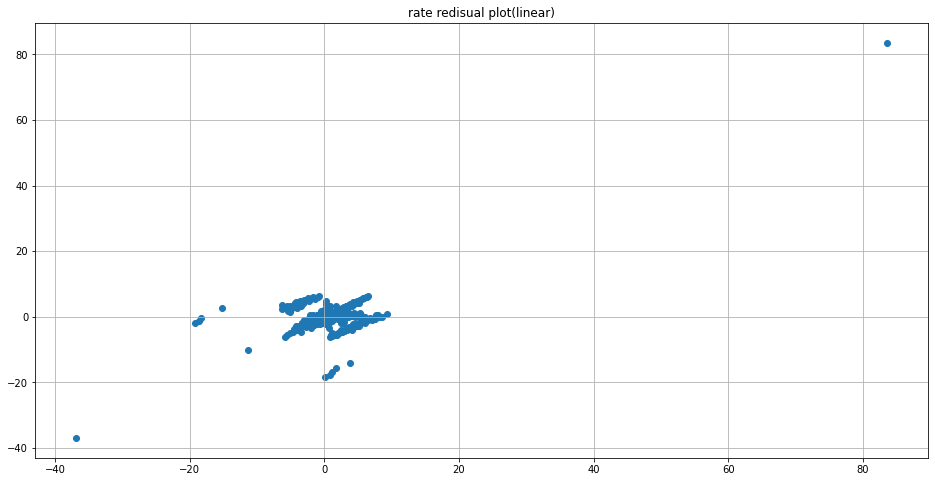

In [21]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_rate_linear'], en_df['pred_rate_linear'] - en_df['real_rate'])
plt.grid(True)
plt.title("rate redisual plot(linear)")
plt.show()

In [22]:
def create_meta_nn(input_dim: int = 129, output_dim: int = 1):
    inputs = layers.Input(shape=(input_dim))
    dense1 = layers.Dense(64, activation=None)(inputs)
    activation1 = layers.Activation(activations.gelu)(dense1)
    dr1 = layers.Dropout(0.5)(activation1)
    dense2 = layers.Dense(16, activation=None)(dr1)
    activation2 = layers.Activation(activations.gelu)(dense2)
    dr2 = layers.Dropout(0.3)(activation2)
    outputs = layers.Dense(1)(dr2)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=losses.mean_squared_error, optimizer=optim.Adam())
    return model

In [23]:
meta_nn = create_meta_nn()
meta_nn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 129)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8320      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0   

In [24]:
def eval_nn(df, features, target):
    kf = StratifiedKFold(n_splits=4, random_state=6174, shuffle=True)
    rmse_scores = np.array([])
    mae_scores = np.array([])
    model_no = 0
    models = {}

    for train_idx, val_idx in kf.split(df, df['collection.name'].values):
        train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

        enc = train_df.groupby(['collection.name'])['target'].mean()
        train_df['target_encoding'] = train_df['collection.name'].map(enc)
        val_df['target_encoding'] = val_df['collection.name'].map(enc)

        train_X, val_X = train_df[features].values, val_df[features].values
        train_y, val_y = train_df[target].values, val_df[target].values

        model = create_meta_nn()
        model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y))
        pred = model.predict(val_X)
        rmse = np.sqrt(mean_squared_error(val_y, pred))
        mae = mean_absolute_error(val_y, pred)

        rmse_scores = np.append(rmse_scores, rmse)
        mae_scores = np.append(mae_scores, mae)

        models[f"model_{model_no}"] = model
        model_no += 1

    print("Use model: Neural Network")
    print(f"RMSE Score: {rmse_scores.mean()}")
    print(f"MAE Score: {mae_scores.mean()}")

    return models

In [25]:
nn_models = eval_nn(en_df, use_cols, target)

Epoch 1/50
159/159 [==============================] - 0s 1ms/step - loss: 1.0322 - val_loss: 0.6690
Epoch 2/50
159/159 [==============================] - 0s 983us/step - loss: 0.7626 - val_loss: 0.6312
Epoch 3/50
159/159 [==============================] - 0s 1ms/step - loss: 0.7251 - val_loss: 0.6068
Epoch 4/50
159/159 [==============================] - 0s 961us/step - loss: 0.6393 - val_loss: 0.5987
Epoch 5/50
159/159 [==============================] - 0s 941us/step - loss: 0.6184 - val_loss: 0.5796
Epoch 6/50
159/159 [==============================] - 0s 956us/step - loss: 0.5861 - val_loss: 0.5825
Epoch 7/50
159/159 [==============================] - 0s 920us/step - loss: 0.5781 - val_loss: 0.5831
Epoch 8/50
159/159 [==============================] - 0s 906us/step - loss: 0.5971 - val_loss: 0.6145
Epoch 9/50
159/159 [==============================] - 0s 909us/step - loss: 0.5583 - val_loss: 0.5980
Epoch 10/50
159/159 [==============================] - 0s 900us/step - loss: 0.5600 - 

In [26]:
X = en_df[use_cols].values
pred = np.zeros((len(X), 1))
for model in nn_models.values():
    pred += model.predict(StandardScaler().fit_transform(X))

en_df['pred_nn'] = pred / 4
en_df['pred_rate_nn'] = en_df['pred_nn'] - en_df['price_1'].apply(lambda x: np.log1p(x))

en_df[['real_rate', 'pred_rate_nn']].describe()

,real_rate,pred_rate_nn
count,13530.000000,13530.000000
mean,0.213703,1.739611
std,1.036265,7.697485
min,-18.044203,-307.977692
25%,-0.044068,-0.409867
50%,0.082541,1.403070
75%,0.303387,3.080133
max,18.749185,95.464841


In [27]:
en_df[['target', 'pred_nn']].describe()

,target,pred_nn
count,13530.000000,13530.000000
mean,1.420694,2.946602
std,1.446046,8.390131
min,0.000000,-307.898418
25%,0.463734,0.674354
50%,1.029619,2.243778
75%,1.856298,3.866086
max,19.336971,95.966827


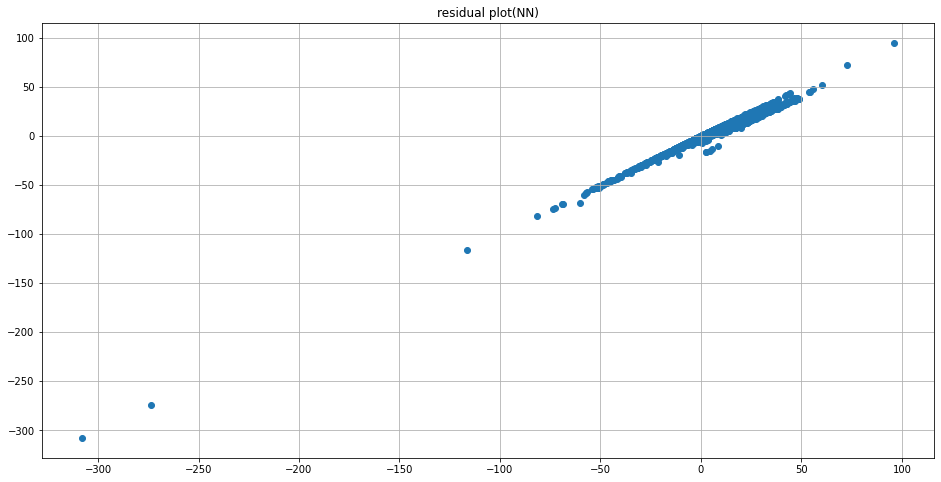

In [28]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_nn'], en_df['pred_nn'] - en_df['target'])
plt.title("residual plot(NN)")
plt.grid(True)
plt.show()

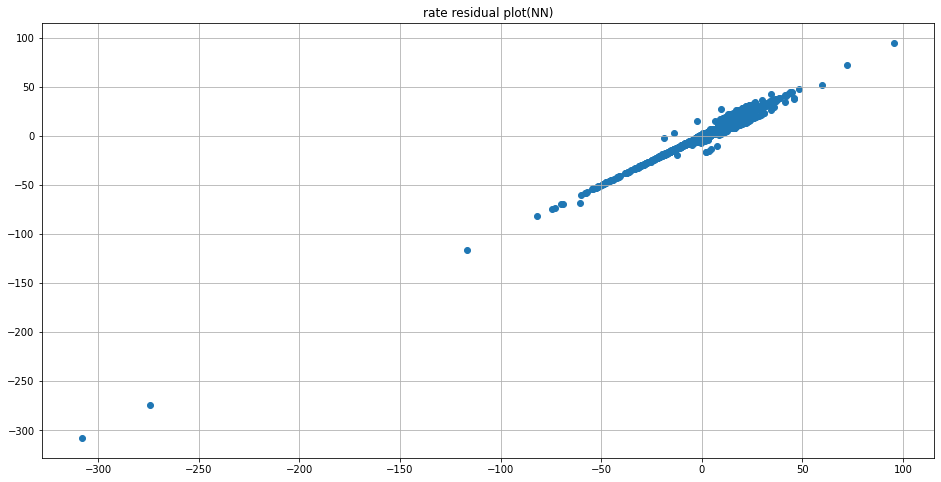

In [29]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_rate_nn'], en_df['pred_rate_nn'] - en_df['real_rate'])
plt.title("rate residual plot(NN)")
plt.grid(True)
plt.show()

In [30]:
print(f"LGBM rate RMSE: {np.sqrt(mean_squared_error(en_df['real_rate'].values, en_df['pred_rate'].values))}")
print(f"LGBM rate MAE: {mean_absolute_error(en_df['real_rate'].values, en_df['pred_rate'].values)}")
print(f"Linear rate RMSE: {np.sqrt(mean_squared_error(en_df['real_rate'].values, en_df['pred_rate_linear'].values))}")
print(f"Linear rate MAE: {mean_absolute_error(en_df['real_rate'].values, en_df['pred_rate_linear'].values)}")
print(f"NN rate RMSE: {np.sqrt(mean_squared_error(en_df['real_rate'].values, en_df['pred_rate_nn'].values))}")
print(f"NN rate MAE: {mean_absolute_error(en_df['real_rate'].values, en_df['pred_rate_nn'].values)}")

LGBM rate RMSE: 0.6196306141164835
LGBM rate MAE: 0.4364644279820369
Linear rate RMSE: 1.0474544656487979
Linear rate MAE: 0.3261771529418606
NN rate RMSE: 7.8384838279165105
NN rate MAE: 3.6362936568994626
